In [102]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [111]:
PATH = os.path.join("dataset", "data_augmented")
df = pd.read_csv("dataset/name_data_augmented.csv", index_col=0)
X = df.filename.values
Y = df.label.values

In [25]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [26]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [83]:
features = {} 
for filename in df.filename.values:
    feature = extract_features(os.path.join(PATH, filename), model)
    features[filename] = feature

In [84]:
# get a list of just the features
feat = np.array(list(features.values()))
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
# get the unique labels 
unique_labels = df.label.unique().tolist()

In [85]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [86]:
kmeans = KMeans(n_clusters=4,n_jobs=2, random_state=22)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=2, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [89]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(X,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
        
        
groups_dict = {}
for group in groups.values():
    labels = [filename.split("_")[0] for filename in group]
    most_common = max(set(labels), key = labels.count)
    groups_dict[most_common] = group            

In [99]:
predict_labels = []
for label in groups_dict.keys():
    for filename in groups_dict[label]:
        predict_labels.append({"filename": filename, "label": label})
predict_labels = pd.DataFrame(predict_labels).set_index("filename")
predict_labels.sort_index(inplace=True)
predict_labels

,label
filename,
DIESTRO_142_4_0_0.jpg,DIESTRO
DIESTRO_142_4_0_0_fliped.jpg,DIESTRO
DIESTRO_142_4_0_1.jpg,DIESTRO
DIESTRO_142_4_0_1_fliped.jpg,DIESTRO
DIESTRO_142_4_0_2.jpg,DIESTRO
...,...
PROESTRO_631_1_90_1_fliped.jpg,PROESTRO
PROESTRO_631_1_90_2.jpg,PROESTRO
PROESTRO_631_1_90_2_fliped.jpg,PROESTRO


In [112]:
df.set_index("filename", inplace=True)
df.sort_index(inplace=True)

In [117]:
confusion_matrix = metrics.confusion_matrix(df.label, predict_labels.label, normalize="true")
confusion_matrix = pd.DataFrame(data=confusion_matrix, columns=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'], 
                                                   index= ['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'])  
confusion_matrix

,DIESTRO,ESTRO,METAESTRO,PROESTRO
DIESTRO,0.643397,0.003528,0.144153,0.208921
ESTRO,0.000000,0.987500,0.005000,0.007500
METAESTRO,0.131048,0.000000,0.778730,0.090222
PROESTRO,0.020250,0.000000,0.289000,0.690750


In [118]:
metrics.accuracy_score(df.label, predict_labels.label)

0.7753514056224899

In [88]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    plt.title(cluster)
    # gets the list of filenames for a cluster
    files = groups_dict[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        #print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(os.path.join(PATH, file))
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 36 to 30


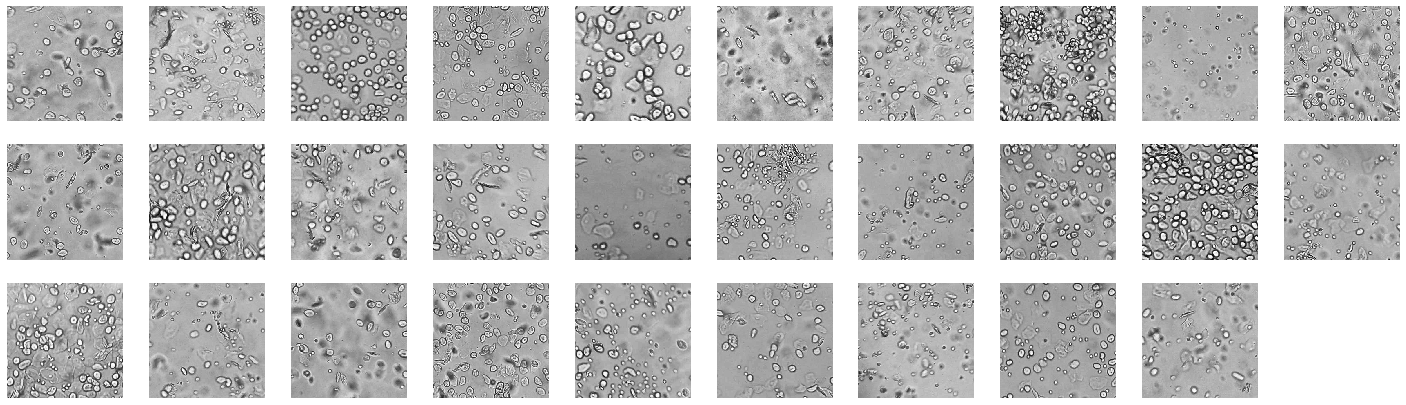

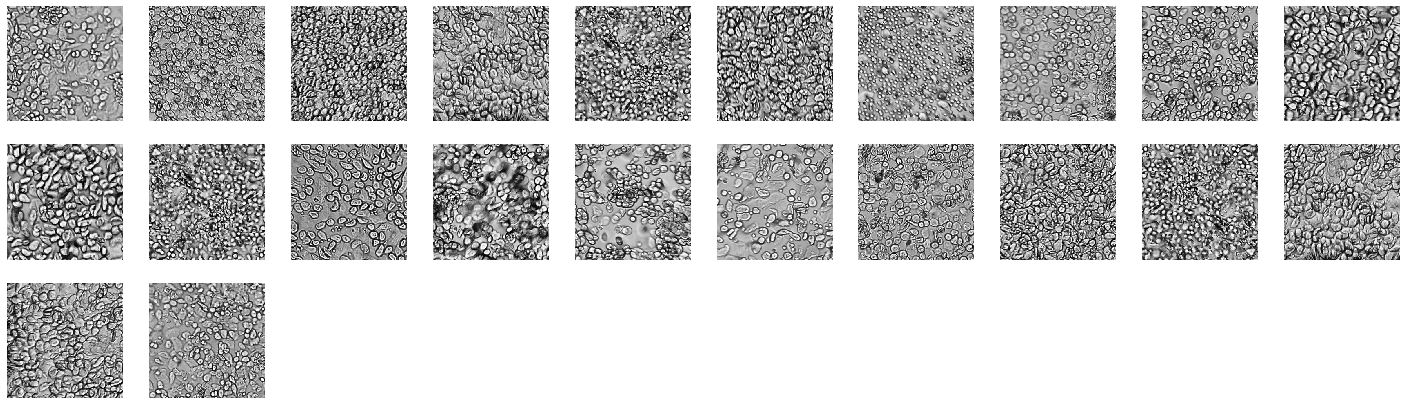

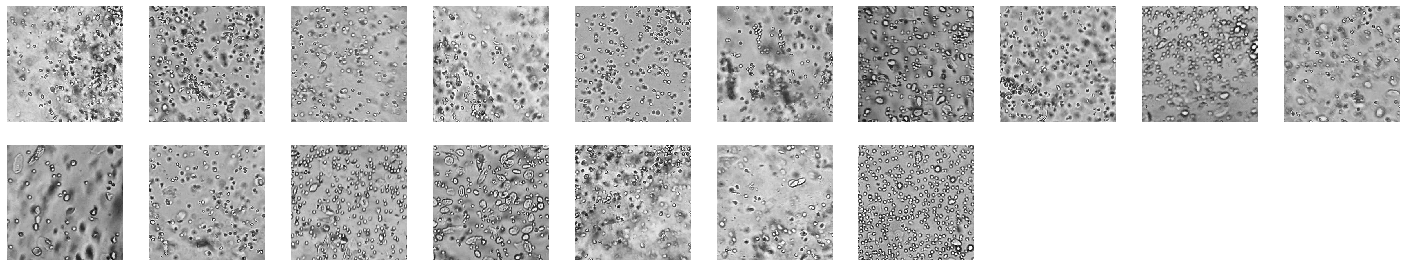

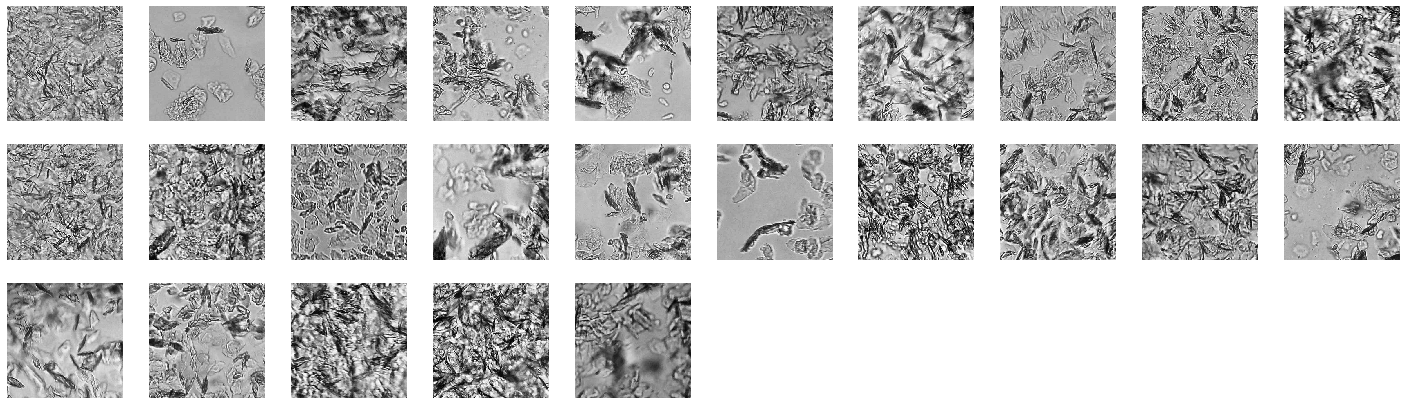

In [81]:
for label in gr:
    view_cluster(label)